# House pricing model
In this notebook we produce a linear regression model from price.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import RegressionAnalysis
ra = RegressionAnalysis.RegressionAnalysis()

In [2]:
dfA = ra.load_data()
df = dfA.query('price < 2*10**6')
df.shape

(21389, 21)

In [3]:
y = df['price'].apply(np.log10)
y.columns = ['log_price']
y.shape

(21389,)

In [4]:
bc_living15, bc_living15_lambda = stats.boxcox(df['sqft_living15'])
len(bc_living15)

21389

In [5]:
bed_density = df['bedrooms'] / df['sqft_living']
bc_bed_density, bc_bed_density_lambda = stats.boxcox(bed_density)
len(bc_bed_density)

21389

In [6]:
bath_bed_ratio = df['bathrooms'] / df['bedrooms']
bc_bath_bed_ratio, bc_bath_bed_ratio_lambda = stats.boxcox(bath_bed_ratio)
len(bc_bath_bed_ratio)

21389

In [7]:
zip_medians = df[['zipcode', 'price']].groupby(by='zipcode').agg('median')
q1, q2 = zip_medians['price'].quantile(q=[1/3, 2/3])
def get_zip_category(price):
    if price < q1:
        category = 'low'
    elif price < q2:
        category = 'med'
    else:
        category = 'high'
    return category
zip_medians['category'] = zip_medians['price'].apply(get_zip_category)
zip_category_map = zip_medians['category'].to_dict()
zip_categories = df['zipcode'].apply(lambda x: zip_category_map[x])
zip_cat_dummies = pd.get_dummies(zip_categories, drop_first=True, prefix='zipcode')
zip_cat_dummies.shape

(21389, 2)

In [8]:
lot_ratio = df['sqft_lot'] / df['sqft_living']
bc_lot_ratio, bc_lot_ratio_lambda = stats.boxcox(lot_ratio)
len(bc_lot_ratio)

21389

In [9]:
X = None
X = zip_cat_dummies
X['bc_living15'] = bc_living15
#X['bc_bed_density'] = bc_bed_density
X['bc_bath_bed_ratio'] = bc_bath_bed_ratio
#X['bc_lot_ratio'] = bc_lot_ratio
#X['grade'] = df['grade']
X.shape

(21389, 4)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

17111 4278 17111 4278


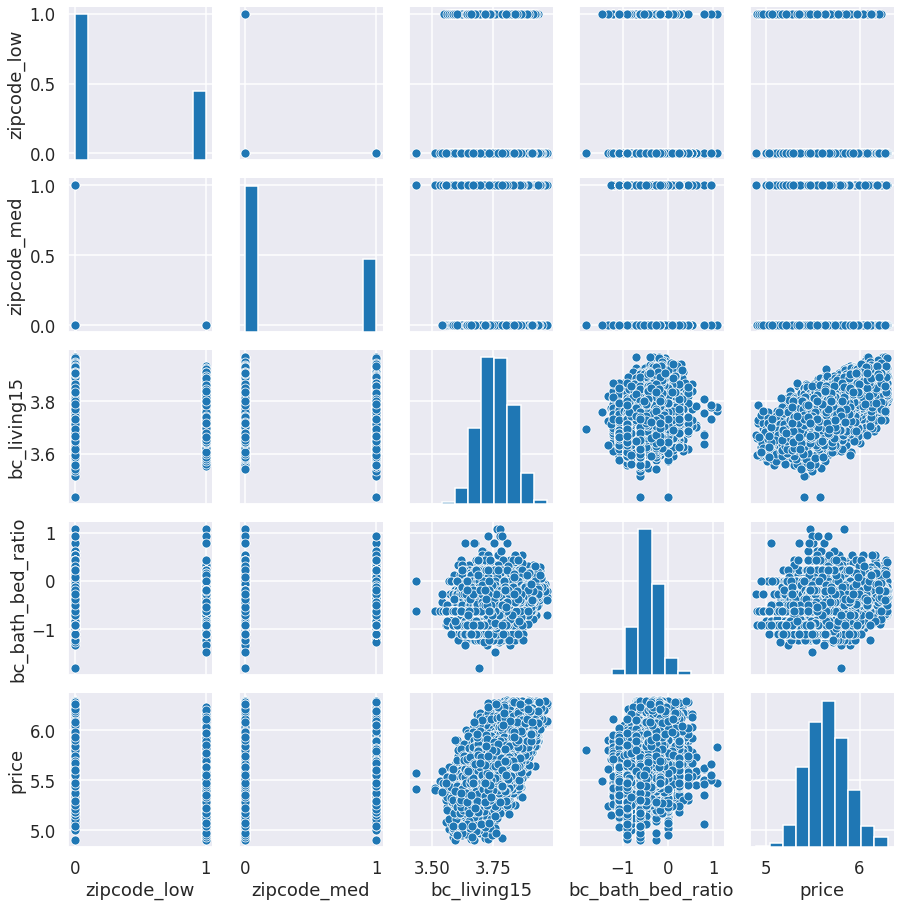

In [11]:
ra.make_pair_plot(pd.concat([X_train,y_train], axis=1))

<AxesSubplot:>

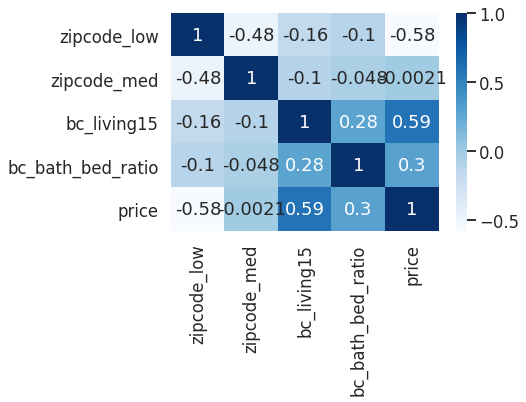

In [12]:
ra.make_correlation_plot(pd.concat([X_train, y_train], axis=1))

In [13]:
model = ra.fit_model(X_train, y_train)

In [14]:
y_hat_train = ra.predict_target(X_train, model)
y_hat_test = ra.predict_target(X_test, model)

In [15]:
residuals_train = ra.compute_residuals(y_train, y_hat_train)

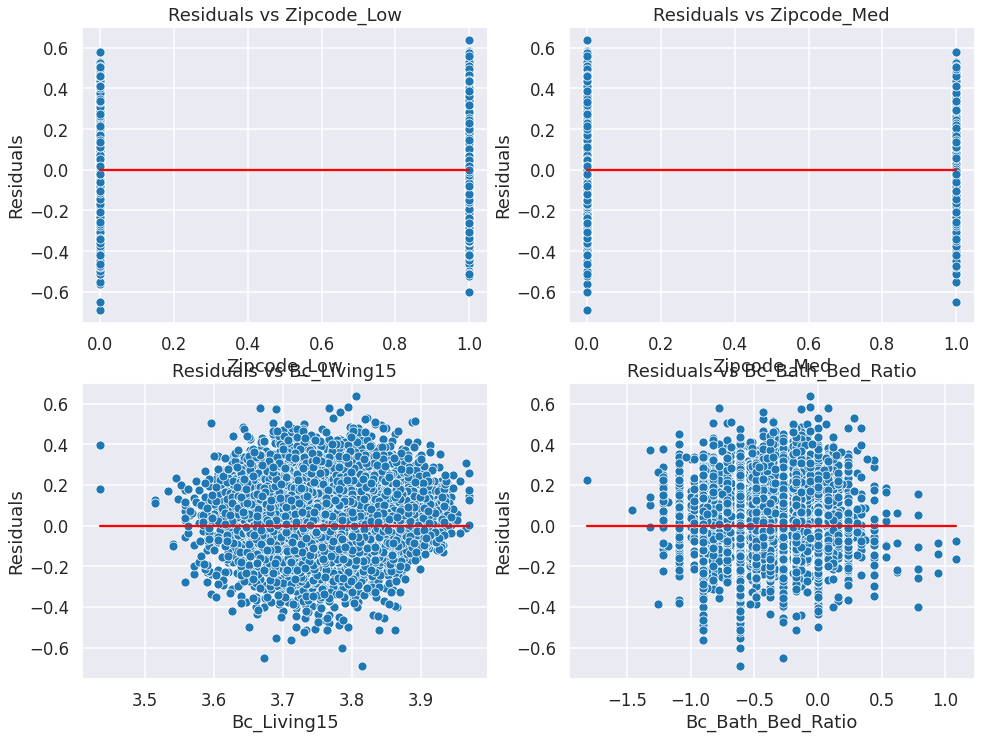

In [16]:
ra.plot_residuals_against_inputs(X_train, residuals_train)

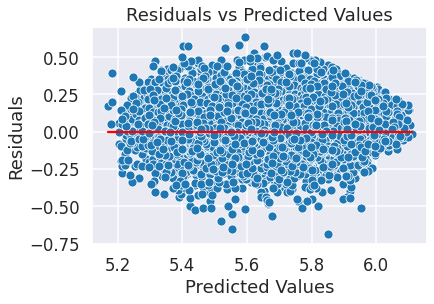

In [17]:
ra.plot_residuals_against_prediction(y_hat_train, residuals_train)

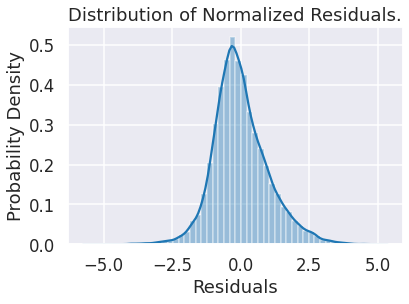

In [18]:
ra.plot_residuals_distribution(residuals_train)

We reject the null hypothesis that our residuals are normally distributed at the alpha =0.05 level.


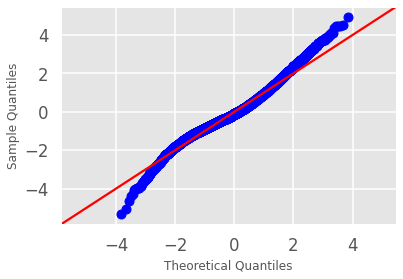

In [19]:
ra.plot_residuals_normal_qq(residuals_train)

In [20]:
ra.compute_vif(X_train)

{'zipcode_low': 1.95,
 'zipcode_med': 1.97,
 'bc_living15': 4.71,
 'bc_bath_bed_ratio': 3.56}

In [21]:
model.score(X_train, y_train)

0.6469466511436766

In [22]:
model.score(X_test, y_test)

0.6232592576017179

In [23]:
price_res_train = ra.compute_residuals(10**y_train, 10**y_hat_train)

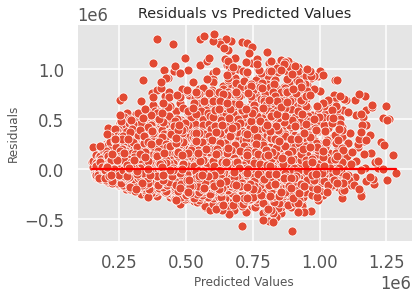

In [24]:
ra.plot_residuals_against_prediction(10**y_hat_train, price_res_train)

In [25]:
X1_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X1_train, hasconst=True).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.647
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     7836.
Date:                Fri, 09 Oct 2020   Prob (F-statistic):               0.00
Time:                        08:21:15   Log-Likelihood:                 10800.
No. Observations:               17111   AIC:                        -2.159e+04
Df Residuals:                   17106   BIC:                        -2.155e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3697      0.061      6.034      0.000       0.250       0.490
zipcode_low          -0.2871      0.002   -115.207      0.000      -0.292      -0.282
zipcode_med          -0.1163      0.002    -47.546      0.000      -0.121      -0.111
bc_living15           1.4489      0.016     90.145      0.000       1.417       1.480
bc_bath_bed_ratio     0.0766      0.004     20.831      0.000       0.069       0.084
==============================================================================
Omnibus:                      965.756   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.958
Skew:                           0.449   Prob(JB):                         0.00
Kurtosis:                       4.231   Cond. No.                         254.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
train_mse = mean_squared_error(10**y_train, 10**y_hat_train)
test_mse = mean_squared_error(10**y_test, 10**y_hat_test)
print('Train Root Mean Squarred Error:', np.sqrt(train_mse))
print('Test Root Mean Squarred Error:', np.sqrt(test_mse))

Train Root Mean Squarred Error: 188059.04980093945
Test Root Mean Squarred Error: 198034.01894235815
